## **Detecting Freezing of Gait Episodes in Parkinson's disease: A Comprehensive Step-by-Step Approach**


Objective: the development of a model to predict Parkinson's freezing-of-gait episodes

**1. Introduction**

Freezing of gait (FOG) is a debilitating symptom that affects individuals diagnosed with Parkinson’s disease, which significantly impacting their ability to walk and limiting their mobility and independence. Machine learning (ML) techniques can provide valuable insights into the occurrence and causes of FOG episodes. By leveraging ML, medical professionals can enhance their evaluation, monitoring, and prevention of FOG events. This notebook is based on Parkinson's Freezing of Gait Prediction competition dataset which includes data collected from a wearable 3D lower back sensor. The goal of this project is detecting the start and stop of each freezing episode, as well as identifying three types of FOG events: Start Hesitation, Turn, and Walking. bold text

**2. The Big Picture**

The objective is to develop a model to detect and predict Parkinson's FOG episodes. These episodes will be predicted based on time series data that was recorded for each patient during the execution of a specific protocol in addition to some provided patient characteristics.
Given the availability of labeled targets in the dataset, a supervised learning approach is suitable for addressing this problem. Since there are multiple targets (Start Hesitation, Turn, and Walking), the problem is a one-class classification. The evaluation metric in this project is the mean average precision, which measures the average precision of predictions for each event class. Thus, accurate predictions of correct event types are more important than predicting all events correctly.
Considering these requirements, this notebook presents a LightGBM (Light Gradient Boosting Model) model developed specifically to optimize the desired evaluation metric.

3.Data Collection

Each patient in the dataset is considered as a subject. The dataset includes two types of experiments conducted to assess conditions of the patient: 1. TDCSFOG dataset: This dataset consists of data series collected in a lab, where subjects completed a FOG-provoking protocol. 1. DeFOG dataset: This dataset comprises data series collected in the subject's home, where the subject also completed a FOG-provoking protocol.
The identification of each series in the TDCSFOG dataset is provided in the "tdcsfog_metadata.csv" file. Each series is uniquely identified by the Subject, Visit, Test, and Medication condition. Similarly, the identification of each series in the DeFOG dataset is given in the "defog_metadata.csv" file, supplied by unique identifiers for Subject, Visit, and Medication condition.

In [1]:
'''
Connecting Google Drive
'''
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
'''
install catboost module
'''
pip install catboost

In [3]:
import pandas as pd
import glob
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import os
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [4]:
'''
Unziping data folder

'''
!unzip gdrive/My\ Drive/tdcsfog.zip > /dev/null

replace tdcsfog/003f117e14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
'''
Creating lab dataset after merging all csv file
'''
csv_folder = '/content/tdcsfog'
df=pd.DataFrame()
for csv_file in os.listdir(csv_folder):
    if csv_file.endswith('.csv'):
        csv_path = os.path.join(csv_folder, csv_file)
        temp_df = pd.read_csv(csv_path)
        df = df.append(temp_df, ignore_index=True)

**4. Data Exploration**

We first look at the subjects dataset.

In [6]:
'''
Displaying shape of data
'''
df.shape

(7062672, 7)

In [7]:
'''
Displaying content of data
'''
df

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.604377,-0.124920,-2.499122,0,0,0
1,1,-9.606579,-0.125581,-2.502086,0,0,0
2,2,-9.604834,-0.122351,-2.505733,0,0,0
3,3,-9.605200,-0.118073,-2.513978,0,0,0
4,4,-9.609752,-0.117230,-2.501336,0,0,0
...,...,...,...,...,...,...,...
7062667,19855,-9.526106,-0.010904,-1.526689,0,0,0
7062668,19856,-9.532375,-0.003922,-1.517218,0,0,0
7062669,19857,-9.532966,0.032062,-1.510481,0,0,0
7062670,19858,-9.511075,0.072181,-1.506021,0,0,0


In [8]:
'''
Checking Unique class in target attribute
'''
df.Turn.value_counts()

0    5383890
1    1678782
Name: Turn, dtype: int64

**5. Data Preprocessing**

In [9]:
def preprocessing_inputs(df):
  df = df.copy()
  # remove unneed col
  unneed_col = ['Time', 'StartHesitation', 'Walking']
  df = df.drop(unneed_col,axis = 1)
   #split Data X,y
  X = df.drop("Turn",axis = 1)
  y = df['Turn']
  # Train test split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
  return X_train,X_test,y_train,y_test

In [10]:
X_train,X_test,y_train,y_test= preprocessing_inputs(df)

In [11]:

X_train

,AccV,AccML,AccAP
1243787,-8.644220,0.199018,3.258654
1661639,-11.151059,2.635285,1.624196
5046776,-9.341660,1.018450,2.822387
1388503,-9.329167,-1.212367,1.847289
4008258,-10.556803,0.077848,1.456491
...,...,...,...
1692743,-7.775115,1.173555,3.796018
6550634,-8.805214,-2.980655,2.731215
6423388,-9.919433,-0.560158,0.146544
6962611,-10.447281,1.417009,3.768919


In [12]:
X_test

,AccV,AccML,AccAP
2830093,-8.566986,0.742893,4.472686
2796382,-9.298530,-0.079686,4.426395
1127746,-9.599682,-2.401167,-0.221998
3901284,-8.134956,0.127589,4.074797
690721,-8.252501,-0.766052,1.571484
...,...,...,...
2216733,-9.161434,-3.639778,2.979754
1391354,-9.561313,-1.094563,2.518842
586871,-8.464296,-0.124944,4.236026
231960,-9.346009,0.663830,-2.217484


In [13]:
y_train

1243787    0
1661639    0
5046776    0
1388503    1
4008258    0
          ..
1692743    0
6550634    0
6423388    0
6962611    0
6413414    0
Name: Turn, Length: 4943870, dtype: int64

In [14]:
y_test

2830093    1
2796382    0
1127746    0
3901284    1
690721     0
          ..
2216733    0
1391354    1
586871     0
231960     0
2065687    1
Name: Turn, Length: 2118802, dtype: int64

In [15]:
import plotly.express as px

In [16]:
fig = px.pie(
    y_train.value_counts(),
    # values='Pass/Fail',
    names=["PASS", "FAIL"],
    title="Class Distribution",
    width=500
)

fig.show()

**6. Model**

Given the availability of labeled targets in the dataset, a supervised learning approach is suitable for addressing this problem. Since there are multiple targets (Fog occur or not while Turn), the problem is a binary-class classification.
The evaluation metric in this project is the mean average precision, which measures the average precision of predictions for each event class. Thus, accurate predictions of correct event types are more important than predicting all events correctly.

**6.1. Model Selection**

For this project, after tuning different ML algorithms, LightGBM algorithm,XGB algorithm,CatBoost algorithm,DecisionTree alogrithm is taken into account for the following reasons.

The dataset is large including many features, so a highly-effiecient model is required.

The task involves Binary-class classification.

The Binary-class problem exhibits imbalanced classes.

It is crucial to capture complex and non-linear relationships in the data.

**6.2. Model Training**

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test):
    # Calculate accuracy
    acc = model.score(X_test, y_test)
    print("Accuracy: {:.2f}%".format(acc * 100))

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Generate a classification report
    clr = classification_report(y_test, y_pred)

    # Create and display a heatmap for the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    # plt.xticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    # plt.yticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print the classification report
    print("Classification Report:\n----------------------\n", clr)

# Example usage
# evaluate_model(model, X_test, y_test)


**7. Prediction and Submission**

The tdcsfog models are evaluated based on their corresponding test data, and the resulting predictions are submitted to the competition. These submissions achieved a placement within the top 20% of participants in the competition.

**Model 1**

DecisionTreeClassification

Accuracy: 70.01%


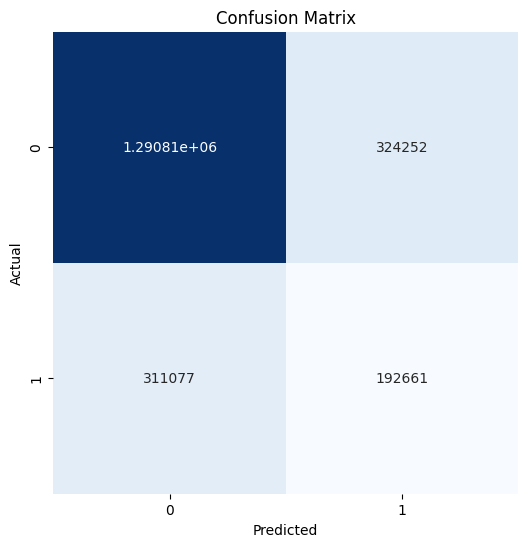

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.81      0.80      0.80   1615064
           1       0.37      0.38      0.38    503738

    accuracy                           0.70   2118802
   macro avg       0.59      0.59      0.59   2118802
weighted avg       0.70      0.70      0.70   2118802



In [19]:
# Fit the model on the training fold
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

'''
Accuracy  : = 70.46%

'''

**Model 2**

XGBoost Classification

Accuracy: 78.56%


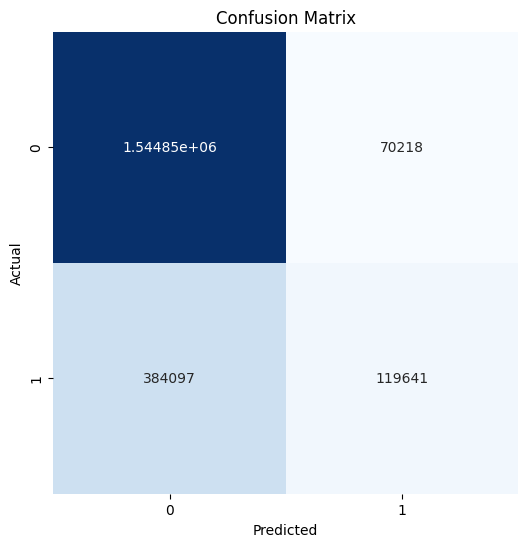

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.80      0.96      0.87   1615064
           1       0.63      0.24      0.34    503738

    accuracy                           0.79   2118802
   macro avg       0.72      0.60      0.61   2118802
weighted avg       0.76      0.79      0.75   2118802



In [20]:
model = XGBClassifier(random_state=123)
model.fit(X_train,y_train)
evaluate_model(model, X_test, y_test)
'''
Accuracy  : = 78.56%

'''

**Model 3**

LightBoost Classification

[LightGBM] [Info] Number of positive: 1175044, number of negative: 3768826
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4943870, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237677 -> initscore=-1.165458
[LightGBM] [Info] Start training from score -1.165458
Accuracy: 78.46%


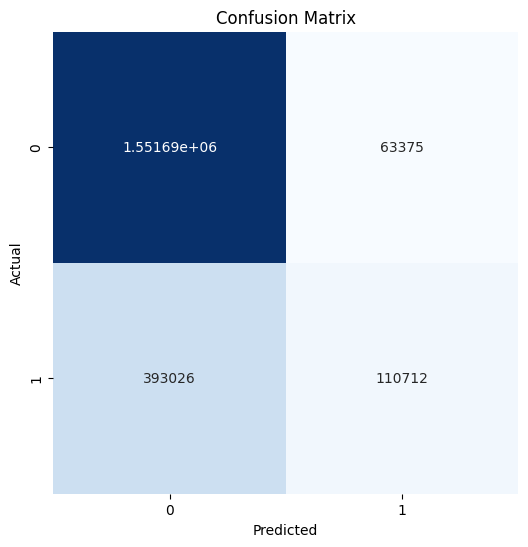

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.80      0.96      0.87   1615064
           1       0.64      0.22      0.33    503738

    accuracy                           0.78   2118802
   macro avg       0.72      0.59      0.60   2118802
weighted avg       0.76      0.78      0.74   2118802



In [21]:
model = LGBMClassifier()
model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)
'''
Accuracy  : = 78.46%

'''

In [22]:
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# evaluate_model(model, X_test, y_test)

**Model 4**

CatBoost Classification

Learning rate set to 0.389315
0:	learn: 0.5449172	total: 2.06s	remaining: 34m 13s
1:	learn: 0.4985695	total: 3.69s	remaining: 30m 44s
2:	learn: 0.4860294	total: 4.84s	remaining: 26m 47s
3:	learn: 0.4813091	total: 5.65s	remaining: 23m 25s
4:	learn: 0.4763829	total: 6.51s	remaining: 21m 35s
5:	learn: 0.4748591	total: 7.31s	remaining: 20m 11s
6:	learn: 0.4719305	total: 8.11s	remaining: 19m 10s
7:	learn: 0.4699889	total: 8.94s	remaining: 18m 28s
8:	learn: 0.4695071	total: 9.7s	remaining: 17m 48s
9:	learn: 0.4680343	total: 10.5s	remaining: 17m 20s
10:	learn: 0.4675930	total: 11.3s	remaining: 16m 53s
11:	learn: 0.4673027	total: 12.1s	remaining: 16m 32s
12:	learn: 0.4671426	total: 12.8s	remaining: 16m 14s
13:	learn: 0.4661241	total: 13.6s	remaining: 16m
14:	learn: 0.4650090	total: 14.4s	remaining: 15m 48s
15:	learn: 0.4644479	total: 15.8s	remaining: 16m 10s
16:	learn: 0.4639646	total: 17.2s	remaining: 16m 35s
17:	learn: 0.4638013	total: 18.8s	remaining: 17m 6s
18:	learn: 0.4635320	total: 19.7

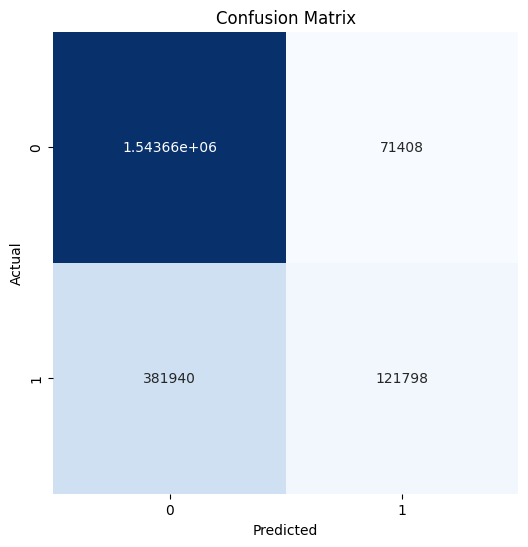

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.80      0.96      0.87   1615064
           1       0.63      0.24      0.35    503738

    accuracy                           0.79   2118802
   macro avg       0.72      0.60      0.61   2118802
weighted avg       0.76      0.79      0.75   2118802



In [23]:
model = CatBoostClassifier()
model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

'''
Accuracy  : = 78.60%

'''

**Serialization**

In [24]:
pickle.dump(model,open('Decision_IMBalanced_LabData.pkl1','wb'))
pickle.dump(model,open('LGBM_IMBalanced_LabData.pkl2','wb'))
pickle.dump(model,open('XGB_IMBlanced_LabData.pkl3','wb'))
# pickle.dump(model,open('Random_IMBlanced_LabData.pkl3','wb'))
pickle.dump(model,open('CatBoost_IMBlanced_LabData.pkl3','wb'))